In [1]:
import numpy as np
import numpy.typing as npt

from matplotlib.axes import Axes
import matplotlib.pyplot as plt

def plot_confusion(ax: Axes, confusion: npt.NDArray, normed: bool = True):

    true_totals = confusion.sum(axis = 1)
    if normed:
        confusion = confusion / true_totals
        true_totals = confusion.sum(axis = 1)

    max_val = true_totals.max()

    im = ax.imshow(confusion, cmap = plt.cm.Blues, vmin = 0, vmax = max_val)
    tick_labels = [f'{f:.02f} Hz' for f in freqs]
    locs = np.arange(len(tick_labels))
    ax.set_yticks(locs)
    ax.set_xticks(locs)
    ax.set_yticklabels(tick_labels, rotation = 90, va = 'center')
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    ax.set_aspect('equal')

    for true_idx in locs:
        for pred_idx in locs:
            val = confusion[true_idx, pred_idx]
            ax.annotate(
                f'{val:.02f}', 
                xy=(pred_idx, true_idx), 
                ha = 'center', 
                va = 'center',
                color = 'white' if val > (max_val / 2) else 'black'
            )

    return im

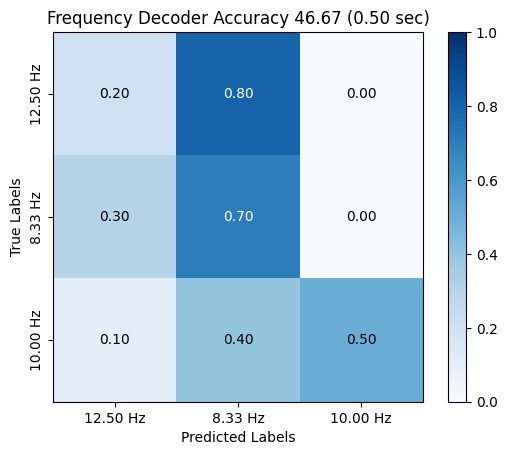

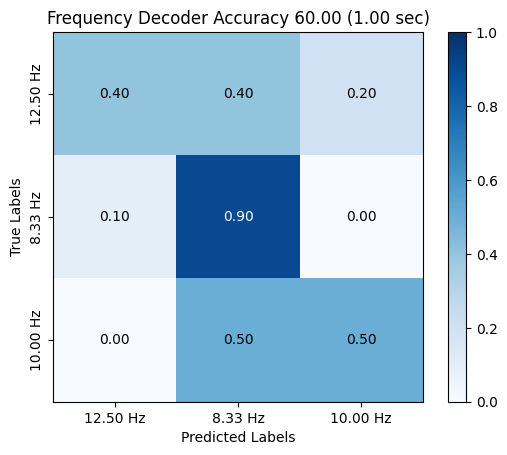

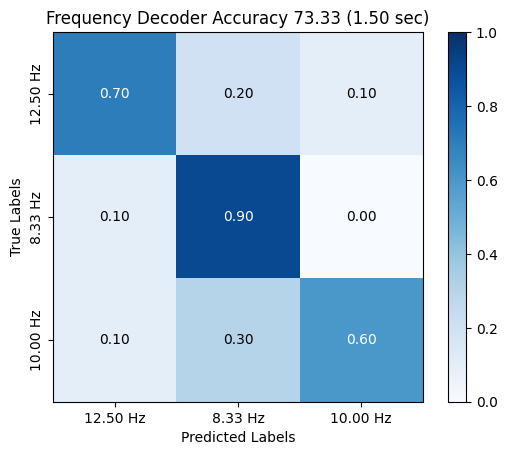

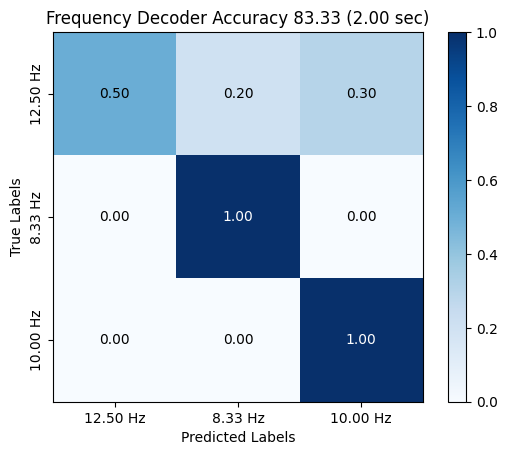

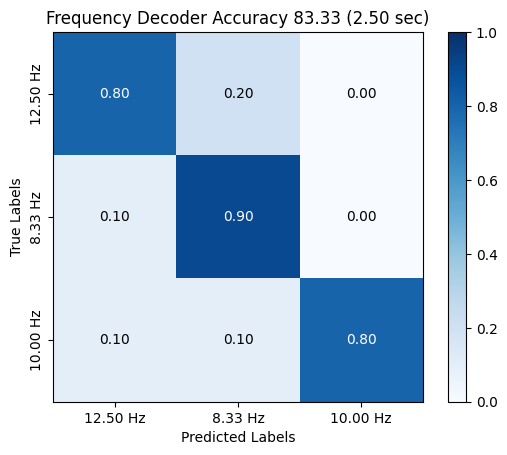

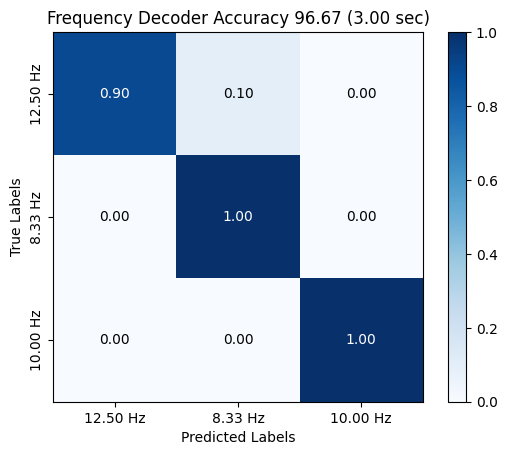

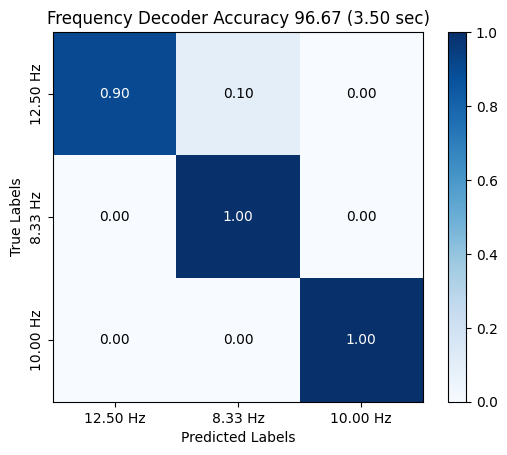

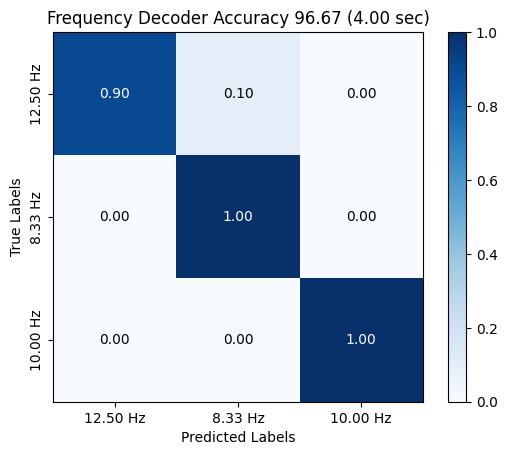

In [11]:
from pathlib import Path
from ezmsg.util.messagecodec import message_log

from bcpi.frequencydecoder import frequency_decode

# data_file = Path.home() / 'ezmsg-tasks' / 'recordings' / 'SSVEP_TEST' / '20240214T151154-SSVEP.txt' # SNR = 6

# data_file = Path.home() / 'bcpi-data' / 'recordings' / 'SSVEP_S0_DRY' / '20240215T151224-SSVEP.txt'
# data_file = Path.home() / 'bcpi-data' / 'recordings' / 'SSVEP_S0_WET' / '20240215T152420-SSVEP.txt'
# data_file = Path.home() / 'bcpi-data' / 'recordings' / 'SSVEP_S0_COTTON' / '20240215T154001-SSVEP.txt'
# data_file = Path.home() / 'bcpi-data' / 'recordings' / 'SSVEP_S1_DRY' / '20240215T155130-SSVEP.txt'
# data_file = Path.home() / 'bcpi-data' / 'recordings' / 'SSVEP_S1_WET' / '20240215T155848-SSVEP.txt'
data_file = Path.home() / 'bcpi-data' / 'recordings' / 'SSVEP_S1_COTTON' / '20240215T160842-SSVEP.txt'

# Assumptions:
# * data_file is readable by message_log (was written by MessageLogger)
# * data_file contains only SampleMessages
# * each SampleMessage has a trigger of type SSVEPTriggerMessage
# * each SSVEPTriggerMessage defines the possible frequencies for decoding (len(trig.freqs) > 0)
# * each of these frequency lists is the same

for int_time in np.linspace(0.5, 4.0, 8):

    decoder = None
    freqs = []
    confusion = np.array([])
    accuracy = []

    for msg in message_log(data_file):
        if decoder is None:
            freqs = msg.trigger.freqs
            decoder = frequency_decode('time', harmonics = 1, freqs = freqs, max_int_time = int_time)
            confusion = np.zeros((len(freqs), len(freqs)))

        decoded = decoder.send(msg)
        if decoded is not None:
            expected_freq = msg.trigger.expected_freq
            decoded_freq = decoded.freqs[np.argmax(decoded.data)]
            accuracy.append(decoded_freq == expected_freq)
            confusion[freqs.index(expected_freq), freqs.index(decoded_freq)] += 1

    fig, ax = plt.subplots(dpi = 100)
    im = plot_confusion(ax, confusion, normed = True)
    fig.colorbar(im)
    ax.set_title(f'Frequency Decoder Accuracy {sum(accuracy)*100.0/len(accuracy):.2f} ({int_time:.2f} sec)')